In [ ]:
!pip install drake

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydot
from copy import deepcopy
from IPython.display import SVG, display, HTML
from pydrake.all import (
    DiagramBuilder,
    DirectCollocation,
    FiniteHorizonLinearQuadraticRegulatorOptions,
    MakeFiniteHorizonLinearQuadraticRegulator,
    PiecewisePolynomial,
    PlanarSceneGraphVisualizer,
    Simulator,
    Solve,
)

import requests
r = requests.get("https://raw.githubusercontent.com/wei-chen-li/wei-chen-li.github.io/refs/heads/main/content/post/triple-pendulum-swingup/notebooks/utils.py")
exec(r.text)

#### Helper functions

In [3]:
def JointState2WorldState(arg1):
    if isinstance(arg1, (int, float)):
        num_states = arg1
    else:
        state = np.array(arg1)
        num_states = len(state)

    assert(num_states % 2 == 0)
    num_pendulums = num_states // 2 - 1
    T = np.block([[np.array([1]), np.zeros((1,num_pendulums))],
                  [np.zeros((num_pendulums,1)), np.tri(num_pendulums)]])
    T = np.block([[T, np.zeros(T.shape)],
                  [np.zeros(T.shape), T]])

    return T if isinstance(arg1, (int, float)) else T.dot(state)

def WorldState2JointState(arg1):
    if isinstance(arg1, (int, float)):
        return np.linalg.inv(JointState2WorldState(arg1))
    else:
        state = np.array(arg1)
        T = JointState2WorldState(len(state))
        return np.linalg.inv(T).dot(state)

### Trajectory optimization

In [25]:
cart_multi_pendulum = CartMultiPendulumSystem(m_cart=1, m1=1,l1=1, m2=1,l2=1, m3=1,l3=1)
num_pendulums = 3

dircol = DirectCollocation(
    cart_multi_pendulum,
    cart_multi_pendulum.CreateDefaultContext(),
    num_time_samples=30,
    minimum_time_step=0.01,
    maximum_time_step=0.1
)
prog = dircol.prog()

x_start = WorldState2JointState([0] * (2 * num_pendulums + 2))
prog.AddBoundingBoxConstraint(x_start, x_start, dircol.initial_state())

x_target = WorldState2JointState([0] + [np.pi] * num_pendulums + [0] * (num_pendulums + 1))
prog.AddBoundingBoxConstraint(x_target, x_target, dircol.final_state())

dircol.AddRunningCost(10 * dircol.input()[0] ** 2)

u_trj_init = PiecewisePolynomial()
x_trj_init = PiecewisePolynomial.FirstOrderHold([0.0, 4.0], np.vstack([x_start, x_target]).T)
dircol.SetInitialTrajectory(u_trj_init, x_trj_init)

result = Solve(prog)
print("Found trajectory? ", result.is_success())

Found trajectory?  True


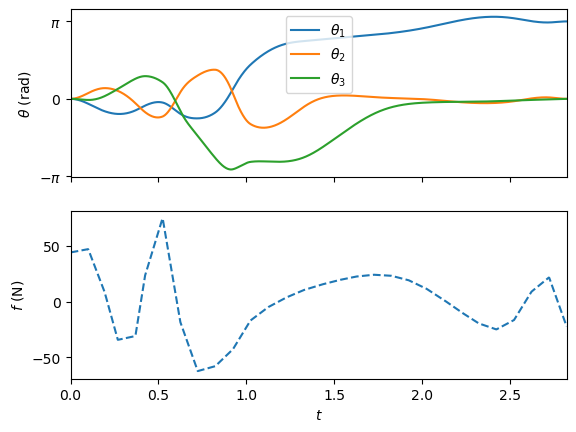

In [26]:
x_trj = dircol.ReconstructStateTrajectory(result)
u_trj = dircol.ReconstructInputTrajectory(result)

t = np.linspace(x_trj.start_time(), x_trj.end_time(), 1000)
x = x_trj.vector_values(t).transpose()
u = u_trj.vector_values(t).transpose()

fig = plt.figure()
ax1, ax2 = fig.subplots(2, 1, sharex=True)

ax1.plot(t, x[:,1:num_pendulums+1])
ax1.legend([rf'$\theta_{i}$' for i in range(1,10)])
ax1.set_ylabel(r'$\theta$ (rad)')
ax1.set_yticks([-np.pi, 0, np.pi])
ax1.set_yticklabels([r'$-\pi$', '$0$', '$\pi$'])

ax2.plot(t, u, '--')
ax2.set_ylabel('$f$ (N)')
ax2.set_xlim(u_trj.start_time(), u_trj.end_time())
ax2.set_xlabel('$t$')

plt.show()

### Trajectory stabilization

In [27]:
Q = np.diag([10] * (num_pendulums+1) + [1] * (num_pendulums+1))
R = np.diag([1])

options = FiniteHorizonLinearQuadraticRegulatorOptions()
options.Qf = Q
options.x0 = x_trj
options.u0 = u_trj

swingup_controller = MakeFiniteHorizonLinearQuadraticRegulator(
    cart_multi_pendulum,
    cart_multi_pendulum.CreateDefaultContext(),
    t0=x_trj.start_time(),
    tf=x_trj.end_time(),
    Q=Q,
    R=R,
    options=options
)

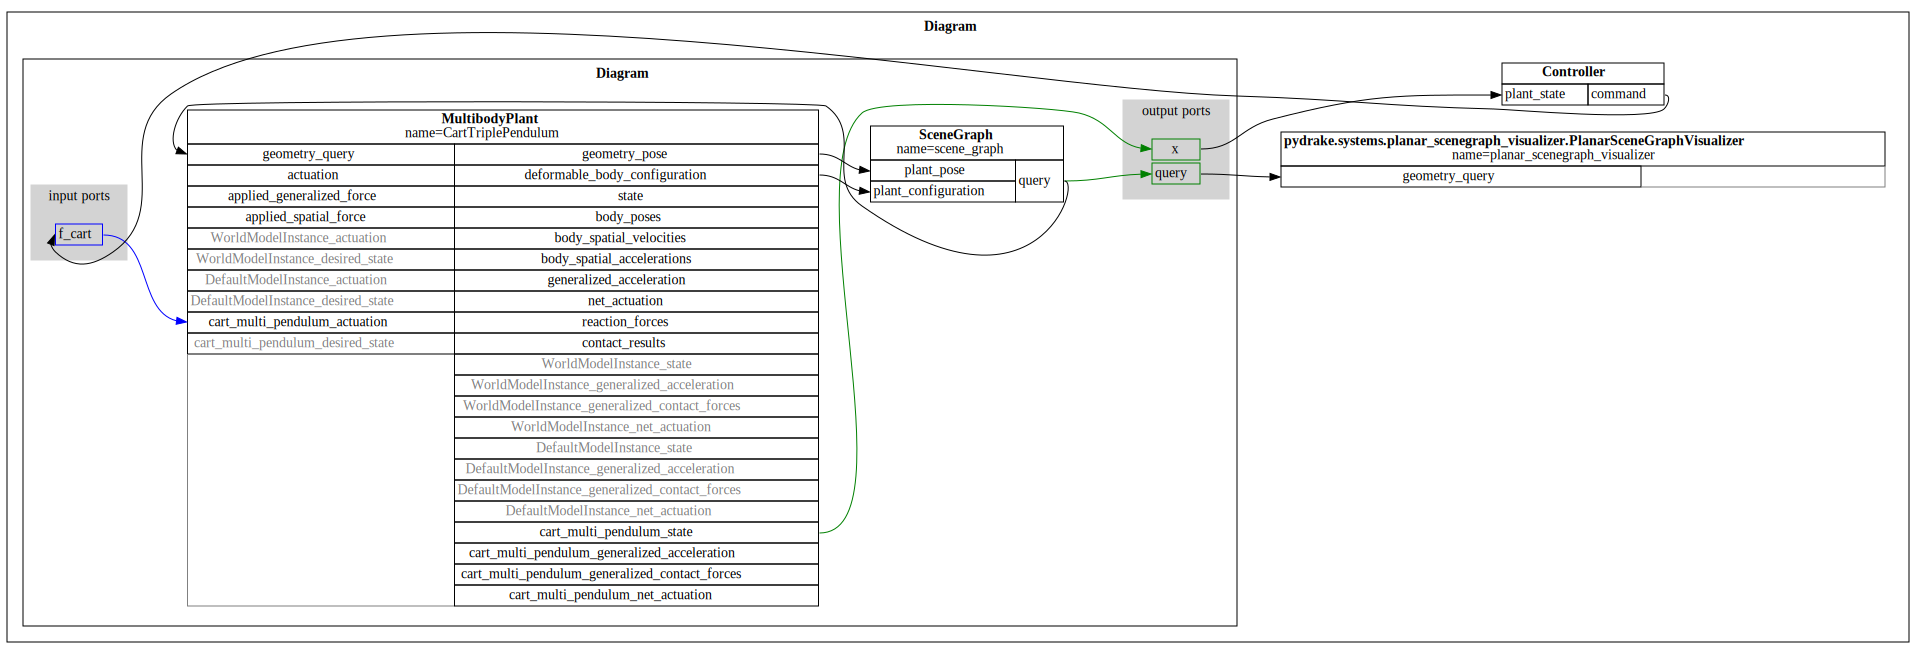

In [28]:
builder = DiagramBuilder()

cart_multi_pendulum = builder.AddSystem(deepcopy(cart_multi_pendulum))

swingup_controller = builder.AddSystem(deepcopy(swingup_controller))
builder.Connect(swingup_controller.get_output_port(), cart_multi_pendulum.get_input_port())
builder.Connect(cart_multi_pendulum.get_output_port(0), swingup_controller.get_input_port())

visualizer = PlanarSceneGraphVisualizer(cart_multi_pendulum.GetSubsystemByName("scene_graph"), show=False)
builder.AddSystem(visualizer)
builder.Connect(cart_multi_pendulum.get_output_port(1), visualizer.get_geometry_query_input_port())

diagram = builder.Build()

display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

In [34]:
simulator = Simulator(diagram)

x0 = [0] * (2*num_pendulums+2)

context = simulator.get_mutable_context()
context.SetTime(0.0)
context.SetContinuousState(x0)

simulator.Initialize()
visualizer.reset_recording()
visualizer.start_recording()
simulator.AdvanceTo(x_trj.end_time())
visualizer.stop_recording()

In [35]:
visualizer.fig.set_size_inches([6, num_pendulums*2.2])
visualizer.ax.set_title('t = ?')
visualizer.fig.tight_layout()
visualizer.ax.set_xlim([-3, 3])
bbox = visualizer.ax.get_position()
bbox.x0, bbox.x1 = 0, 1
visualizer.ax.set_position(bbox)

HTML(visualizer.get_recording_as_animation().to_jshtml())

In [33]:
with open('tmp.html', 'w') as f:
    f.write(visualizer.get_recording_as_animation().to_html5_video())